In [1]:
import pandas as pd
import numpy as np
import copy
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
curr_dir = os.getcwd()
dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\CT15Mn-150818_101018\\dados_camara.csv")#dados mais recentes
tomtom = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\tomtom_data.csv")
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\periodic_data.csv") #dados periodicos gerados automaticamente
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\dados_old.csv") #dados mais antigos
dataset['unique_id'] = dataset.Zona.astype(str) + '_' + dataset.ID_Espira.astype(str)
dataset['unique_id'] = dataset['unique_id'].str.lower()
dataset = dataset[dataset["unique_id"] == "4_ct4"]

dataset = dataset.drop(columns=["Zona","Contadores","ID_Espira","unique_id"])
dt2 = copy.deepcopy(dataset)
#dataset.sort_values(['Data'],ascending=True).groupby('Data').reset_index()

dataset = dataset.groupby('Data').apply(lambda x: x.reset_index())

msk = np.random.rand(len(dt2)) < 0.7
train_df = dt2[msk]
test_df = dt2[~msk]





dt2.to_csv("limited_data.csv", sep= ',', index=False)
#train_set
train_df.to_csv("train.csv", sep= ',', index=False)

#test_set
test_df.to_csv("test.csv", sep= ',', index=False)

#full set
dataset = dataset.drop(columns=["index"])
dataset.to_csv("dados_nn.csv", sep=',', index=False)



In [2]:
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
hours = [dt.strftime('%H:%M') for dt in datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), timedelta(minutes=15))]

In [3]:
#smoothing using std_dev and mean
from scipy import stats
import statistics


import numpy as np

train_cp = copy.deepcopy(train_df)
test_cp = copy.deepcopy(test_df)

def smooth_data(train_cp,filename):
    data = train_cp.iloc[:,0]
    print(data.values)
    train_cp = train_cp.drop(columns=["Data"])
    train_cp = train_cp.values

    #train_cp = train_cp.astype('float32')

    avg_list = []
    std_list = []
    for i in range(len(train_cp[0])):
        curr_avg = sum(train_cp[:,i])/len(train_cp[:,i])
        avg_list.append(curr_avg)
        std_list.append(statistics.stdev(train_cp[:,i]))
    #FIX sera que e preciso guardar os valores antigos e usá-los para fazer os updates? 
    #agora esta a fazer uma especie de moving average, utilizando os valores novos nos updates seguintes


    
    for row in range(len(train_cp)):
        number_of_changes= 0
        for column in range(len(train_cp[0])):
            if (train_cp[row][column] > (avg_list[column] + 2*std_list[column])):
                old_value = train_cp[row][column]
                if column == 0:
                    previous_t = train_cp[row,-1]
                    next_t = train_cp[row,column+1]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                if column == 95:
                    previous_t = train_cp[row,column-1]
                    next_t = train_cp[row,0]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                else:
                    previous_t = train_cp[row,column-1]
                    next_t = train_cp[row,column+1]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                new_value = train_cp[row][column]
        print("Number of changes: " + str(number_of_changes))
                
    new_d = data.values.reshape(len(data.values),1)
    test = np.concatenate((new_d,train_cp),axis=1)
    pd.DataFrame(test).to_csv(str(filename) + ".csv", sep=',', index=False)
    return test, train_cp
smooth_train, df_train= smooth_data(train_cp, "train_2")
smooth_test, df_test = smooth_data(test_cp, "test_2")


['2018-09-01' '2018-09-02' '2018-08-16' '2018-08-17' '2018-08-20'
 '2018-08-21' '2018-08-22' '2018-08-23' '2018-08-25' '2018-08-26'
 '2018-08-27']
Number of changes: 3
Number of changes: 1
Number of changes: 0
Number of changes: 0
Number of changes: 1
Number of changes: 0
Number of changes: 0
Number of changes: 1
Number of changes: 2
Number of changes: 1
Number of changes: 0
['2018-08-15' '2018-08-18' '2018-08-19' '2018-08-24']
Number of changes: 0
Number of changes: 1
Number of changes: 1
Number of changes: 0


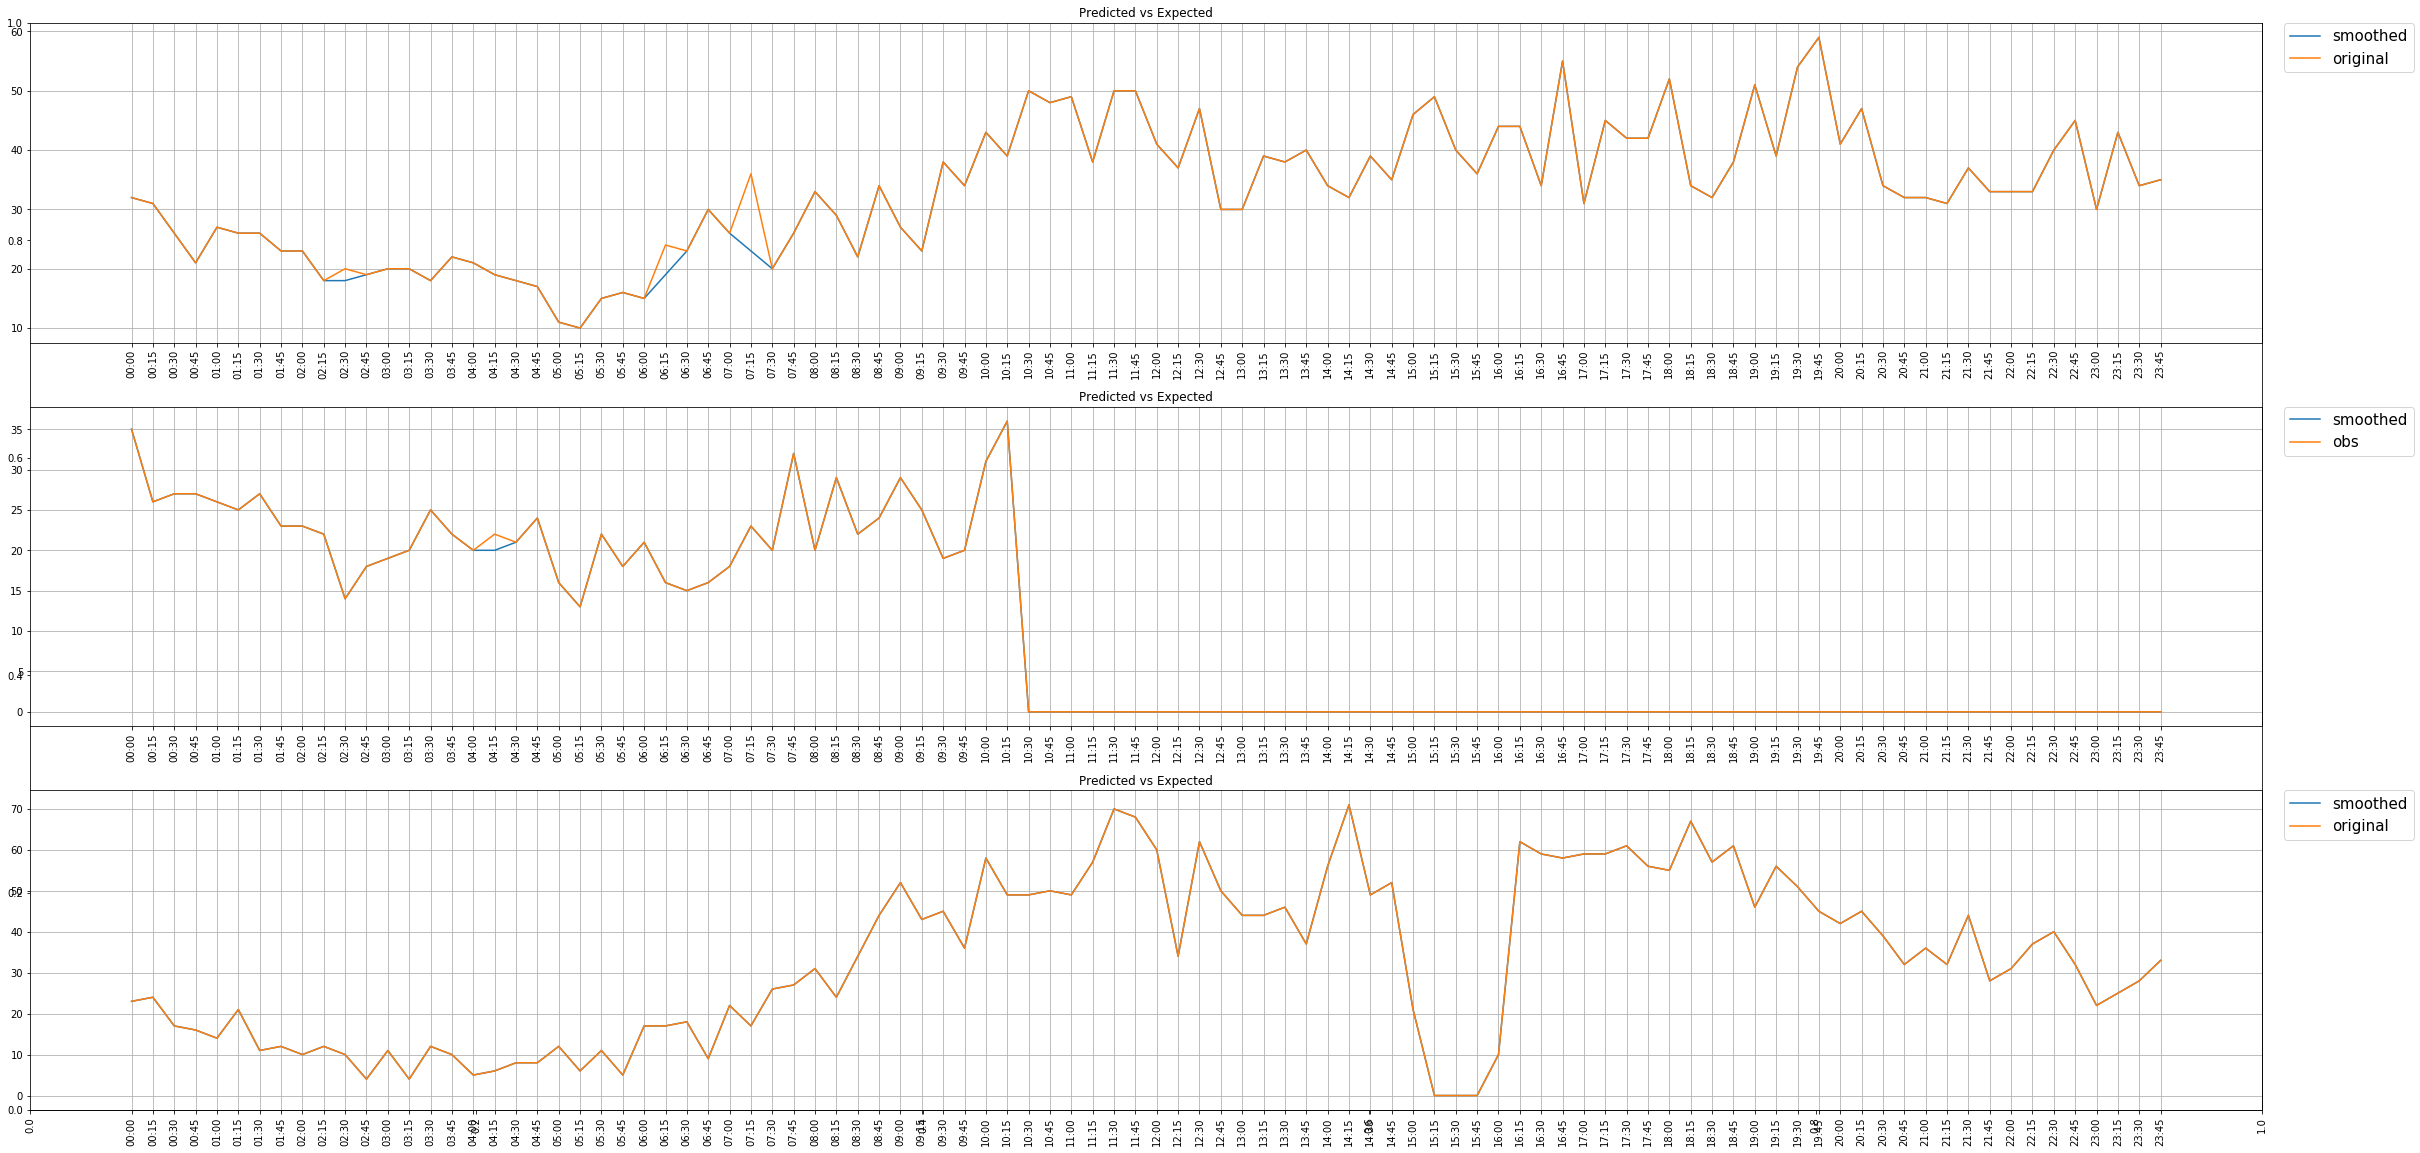

In [4]:
hours = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]


dataframe = pd.read_csv('train.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
train = dataset.astype('float32')

dataframe = pd.read_csv('test.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
test = dataset.astype('float32')

def plot_changes(original, smooth):
    fig = plt.figure(2)

    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(hours,smooth[0], label="smoothed")
    ax.plot(hours,original[0], label="original")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax = fig.add_subplot(312)
    ax.plot(hours,smooth[1], label="smoothed")
    ax.plot(hours,original[1], label="obs")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax = fig.add_subplot(313)
    ax.plot(hours,smooth[2], label="smoothed")
    ax.plot(hours,original[2], label="original")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig(curr_dir + "\\smoothing\\" +"avg_2stdev.png", dpi=200)
plot_changes(train, df_train)

In [5]:
def transform_data(in_file, out_file, nrows=-1):
    in_file = open(str(in_file),"r")
    next(in_file)
    out_file = open(str(out_file),"w")
    out_file.write("t-3,t-2,t-1,Y\n") #header
    k = 0    
    lines = in_file.readlines()
    for line in lines:
        line = line.split(",")
        line = line[1:]
        line[-1] = line[-1].replace("\n","") #last data record has a \n
        its = [iter(line), iter(line[1:]), iter(line[2:]),iter(line[3:])] #Construct the pattern for longer windowss
        x = list(zip(*its))
        if (k == nrows):
            break
            
        k+=1 
#print(x)
    #j = 0
    #while(j<50): #this cycle was for creating a mock dataset with repeated data for testing purposes
        for i in x:
        #print(i[0],i[1],i[2],i[3])
            out_file.write(i[0] + "," + i[1] +"," + i[2] +","+ i[3])
            out_file.write("\n")
     #   j+=1
    
    in_file.close()
    out_file.close()
transform_data("dados_nn.csv", "new_f.csv")
transform_data("dados_nn.csv", "3day_nn.csv", 3)
transform_data("train2.csv", "smoothed_data.csv")
transform_data("test_2.csv", "test_formatted.csv")
transform_data("test_2.csv", "3day_unsmoothed.csv",3)
transform_data("train_2.csv", "train_formatted.csv")


In [12]:
out_file = open("new_f.csv","w")
out_file.write("t-4,t-3,t-2,t-1,Y\n")
in_file = open("dados_nn.csv","r")
next(in_file)
lines = in_file.readlines()
for line in lines:
    line = line.split(",")
    line = line[2:]
    line[-1] = line[-1].replace("\n","")
    its = [iter(line), iter(line[1:]), iter(line[2:]),iter(line[3:]), iter(line[4:])] #Construct the pattern for longer windowss
    x = list(zip(*its))
    for i in x:
        #print(i[0],i[1],i[2],i[3])
        out_file.write(i[0] + "," + i[1] +"," + i[2] +","+ i[3] + "," + i[4])
        out_file.write("\n")    
out_file.close()

In [25]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import sys

# fix random seed for reproducibility
#numpy.random.seed(7)

#dataframe = pd.read_csv('new_f.csv') #raw data
#dataset = dataframe.values
#dataset = dataset.astype('float32')
#dataframe = pd.read_csv('test.csv') #data generated by reusing the same day 50 times


dataframe = pd.read_csv('train_formatted.csv')
dataset = dataframe.values
train_set = dataset.astype('float32')

dataframe = pd.read_csv('test_formatted.csv')
dataset = dataframe.values
test_set = dataset.astype('float32')


def create_dataset(data):
    X,Y = [],[]
    for i in data:
        X.append(i[:3])
        Y.append(i[3])
    return numpy.array(X), numpy.array(Y)
print(len(train_set))
print(len(test_set))
trainX, trainY = create_dataset(train_set)
testX, testY = create_dataset(test_set)
model = Sequential()
layer1 = Dense(1,input_dim=3, activation='relu')
layer2 = Dense(3, activation='relu')
#layer3 = Dense(32, activation='relu')
#layer3 = Dense(400, activation='relu')
model.add(layer1)
model.add(layer2)
#model.add(layer3)
#model.add(Dense(8, activation='relu'))
model.add(Dense(1))
sgd = optimizers.SGD(lr=0.001)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=rmsprop,metrics=['mape', 'mae', 'mse'])
model.fit(trainX, trainY, epochs=400, verbose=2)

1023
372
Epoch 1/400
 - 0s - loss: 1417.2529 - mean_absolute_percentage_error: 1296767.1022 - mean_absolute_error: 32.7016 - mean_squared_error: 1417.2529
Epoch 2/400
 - 0s - loss: 1414.7827 - mean_absolute_percentage_error: 3290975.3118 - mean_absolute_error: 32.6685 - mean_squared_error: 1414.7827
Epoch 3/400
 - 0s - loss: 1412.4300 - mean_absolute_percentage_error: 5238207.0859 - mean_absolute_error: 32.6366 - mean_squared_error: 1412.4300
Epoch 4/400
 - 0s - loss: 1409.8273 - mean_absolute_percentage_error: 7365746.1878 - mean_absolute_error: 32.6025 - mean_squared_error: 1409.8273
Epoch 5/400
 - 0s - loss: 1407.2490 - mean_absolute_percentage_error: 9503503.0696 - mean_absolute_error: 32.5670 - mean_squared_error: 1407.2490
Epoch 6/400
 - 0s - loss: 1404.4513 - mean_absolute_percentage_error: 11900981.4936 - mean_absolute_error: 32.5302 - mean_squared_error: 1404.4513
Epoch 7/400
 - 0s - loss: 1401.5369 - mean_absolute_percentage_error: 13999005.2495 - mean_absolute_error: 32.4907

Epoch 58/400
 - 0s - loss: 64.9405 - mean_absolute_percentage_error: 198013986.0578 - mean_absolute_error: 6.0027 - mean_squared_error: 64.9405
Epoch 59/400
 - 0s - loss: 64.5182 - mean_absolute_percentage_error: 196575039.9886 - mean_absolute_error: 5.9771 - mean_squared_error: 64.5182
Epoch 60/400
 - 0s - loss: 63.9343 - mean_absolute_percentage_error: 197180382.7782 - mean_absolute_error: 5.9436 - mean_squared_error: 63.9343
Epoch 61/400
 - 0s - loss: 63.5086 - mean_absolute_percentage_error: 198980483.0728 - mean_absolute_error: 5.9216 - mean_squared_error: 63.5086
Epoch 62/400
 - 0s - loss: 63.1303 - mean_absolute_percentage_error: 197717187.3689 - mean_absolute_error: 5.9134 - mean_squared_error: 63.1303
Epoch 63/400
 - 0s - loss: 62.6333 - mean_absolute_percentage_error: 198887130.6191 - mean_absolute_error: 5.8787 - mean_squared_error: 62.6333
Epoch 64/400
 - 0s - loss: 62.2796 - mean_absolute_percentage_error: 197190897.5810 - mean_absolute_error: 5.8566 - mean_squared_error: 

Epoch 115/400
 - 0s - loss: 55.1753 - mean_absolute_percentage_error: 202604087.0647 - mean_absolute_error: 5.5021 - mean_squared_error: 55.1753
Epoch 116/400
 - 0s - loss: 55.1579 - mean_absolute_percentage_error: 202803805.3036 - mean_absolute_error: 5.4937 - mean_squared_error: 55.1579
Epoch 117/400
 - 0s - loss: 55.0252 - mean_absolute_percentage_error: 202481319.8592 - mean_absolute_error: 5.4856 - mean_squared_error: 55.0252
Epoch 118/400
 - 0s - loss: 55.0637 - mean_absolute_percentage_error: 202642041.3808 - mean_absolute_error: 5.4825 - mean_squared_error: 55.0637
Epoch 119/400
 - 0s - loss: 55.1285 - mean_absolute_percentage_error: 203543515.3709 - mean_absolute_error: 5.4973 - mean_squared_error: 55.1285
Epoch 120/400
 - 0s - loss: 55.0141 - mean_absolute_percentage_error: 203918397.1795 - mean_absolute_error: 5.5030 - mean_squared_error: 55.0141
Epoch 121/400
 - 0s - loss: 54.9900 - mean_absolute_percentage_error: 202641903.5194 - mean_absolute_error: 5.4975 - mean_squared_

Epoch 172/400
 - 0s - loss: 54.2353 - mean_absolute_percentage_error: 198415043.0566 - mean_absolute_error: 5.4309 - mean_squared_error: 54.2353
Epoch 173/400
 - 0s - loss: 54.3429 - mean_absolute_percentage_error: 198096876.9935 - mean_absolute_error: 5.4346 - mean_squared_error: 54.3429
Epoch 174/400
 - 0s - loss: 54.3008 - mean_absolute_percentage_error: 197279714.9221 - mean_absolute_error: 5.4340 - mean_squared_error: 54.3008
Epoch 175/400
 - 0s - loss: 53.9641 - mean_absolute_percentage_error: 198075931.9207 - mean_absolute_error: 5.4268 - mean_squared_error: 53.9641
Epoch 176/400
 - 0s - loss: 54.0778 - mean_absolute_percentage_error: 196482574.1182 - mean_absolute_error: 5.4166 - mean_squared_error: 54.0778
Epoch 177/400
 - 0s - loss: 54.3626 - mean_absolute_percentage_error: 197731459.1076 - mean_absolute_error: 5.4439 - mean_squared_error: 54.3626
Epoch 178/400
 - 0s - loss: 54.2821 - mean_absolute_percentage_error: 196828000.5078 - mean_absolute_error: 5.4293 - mean_squared_

Epoch 229/400
 - 0s - loss: 53.9974 - mean_absolute_percentage_error: 193582042.2736 - mean_absolute_error: 5.4101 - mean_squared_error: 53.9974
Epoch 230/400
 - 0s - loss: 53.9516 - mean_absolute_percentage_error: 193052568.9925 - mean_absolute_error: 5.4078 - mean_squared_error: 53.9516
Epoch 231/400
 - 0s - loss: 54.1048 - mean_absolute_percentage_error: 191858221.8154 - mean_absolute_error: 5.4082 - mean_squared_error: 54.1048
Epoch 232/400
 - 0s - loss: 54.0441 - mean_absolute_percentage_error: 192197134.0108 - mean_absolute_error: 5.4062 - mean_squared_error: 54.0441
Epoch 233/400
 - 0s - loss: 53.9045 - mean_absolute_percentage_error: 192732567.7907 - mean_absolute_error: 5.4050 - mean_squared_error: 53.9045
Epoch 234/400
 - 0s - loss: 53.9016 - mean_absolute_percentage_error: 191044514.6930 - mean_absolute_error: 5.3942 - mean_squared_error: 53.9016
Epoch 235/400
 - 0s - loss: 54.0455 - mean_absolute_percentage_error: 192851634.8882 - mean_absolute_error: 5.3940 - mean_squared_

Epoch 286/400
 - 0s - loss: 54.0217 - mean_absolute_percentage_error: 190405106.7573 - mean_absolute_error: 5.4039 - mean_squared_error: 54.0217
Epoch 287/400
 - 0s - loss: 53.9243 - mean_absolute_percentage_error: 188149494.8773 - mean_absolute_error: 5.3955 - mean_squared_error: 53.9243
Epoch 288/400
 - 0s - loss: 54.0021 - mean_absolute_percentage_error: 189442422.4817 - mean_absolute_error: 5.3940 - mean_squared_error: 54.0021
Epoch 289/400
 - 0s - loss: 53.8517 - mean_absolute_percentage_error: 188934841.3428 - mean_absolute_error: 5.3934 - mean_squared_error: 53.8517
Epoch 290/400
 - 0s - loss: 53.6813 - mean_absolute_percentage_error: 188899231.1601 - mean_absolute_error: 5.3942 - mean_squared_error: 53.6813
Epoch 291/400
 - 0s - loss: 54.0177 - mean_absolute_percentage_error: 189085191.7430 - mean_absolute_error: 5.3978 - mean_squared_error: 54.0177
Epoch 292/400
 - 0s - loss: 53.9360 - mean_absolute_percentage_error: 188199745.8041 - mean_absolute_error: 5.3856 - mean_squared_

Epoch 343/400
 - 0s - loss: 53.8885 - mean_absolute_percentage_error: 184534739.3358 - mean_absolute_error: 5.3817 - mean_squared_error: 53.8885
Epoch 344/400
 - 0s - loss: 53.9281 - mean_absolute_percentage_error: 186290323.1474 - mean_absolute_error: 5.3970 - mean_squared_error: 53.9281
Epoch 345/400
 - 0s - loss: 54.0372 - mean_absolute_percentage_error: 185906042.2289 - mean_absolute_error: 5.3924 - mean_squared_error: 54.0372
Epoch 346/400
 - 0s - loss: 53.9760 - mean_absolute_percentage_error: 185682689.8390 - mean_absolute_error: 5.3876 - mean_squared_error: 53.9760
Epoch 347/400
 - 0s - loss: 53.9668 - mean_absolute_percentage_error: 185828226.8729 - mean_absolute_error: 5.3828 - mean_squared_error: 53.9668
Epoch 348/400
 - 0s - loss: 53.6734 - mean_absolute_percentage_error: 184775674.7560 - mean_absolute_error: 5.3783 - mean_squared_error: 53.6734
Epoch 349/400
 - 0s - loss: 53.8993 - mean_absolute_percentage_error: 186688223.1084 - mean_absolute_error: 5.3918 - mean_squared_

Epoch 400/400
 - 0s - loss: 53.8557 - mean_absolute_percentage_error: 182921129.6298 - mean_absolute_error: 5.3733 - mean_squared_error: 53.8557


In [46]:
import math

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print(model.metrics_names)
print(trainScore)
#print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print(testScore)

#print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#print(trainPredict)
#print(trainY)
#print(testPredict)
#print(testY)
layers_conf = []
units = []
activation = []
for i in range(len(model.layers)):
    layer = model.layers[i].get_config()
    layers_conf.append(layer)
    units.append(layer["units"])
    activation.append(layer["activation"])
    #print(layer["units"])
    #print(layer["activation"])
if (os.stat("metrics_comparison.txt").st_size == 0):
    f = open("metrics_comparison.txt", "w+")
    f.write("N_layers,[units per layer], [activations]," + "\n")
    f.write("Metrics names: "  + str(model.metrics_names)+ "\n\n")
    
    f.write(str(len(layers_conf)) + "," + str(units) + "," +  str(activation) +"\n")
    f.write("Train Set metrics :"  + str(trainScore) +"\n")
    f.write("Test Set metrics :"  + str(testScore) +"\n\n\n")
    f.close()
else:
    f = open("metrics_comparison.txt", "a+")
    f.write(str(len(layers_conf)) + "," + str(units) + "," +  str(activation) +"\n")
    f.write("Train Set metrics :"  + str(trainScore) +"\n")
    f.write("Test Set metrics :"  + str(testScore) +"\n\n\n")
    f.close()
    

['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_error']
[53.82626114189916, 182241868.5763058, 5.365349465218224, 53.82626114189916]
[41.49908287294449, 19.56262041932793, 4.9894483884175616, 41.49908287294449]


93
93


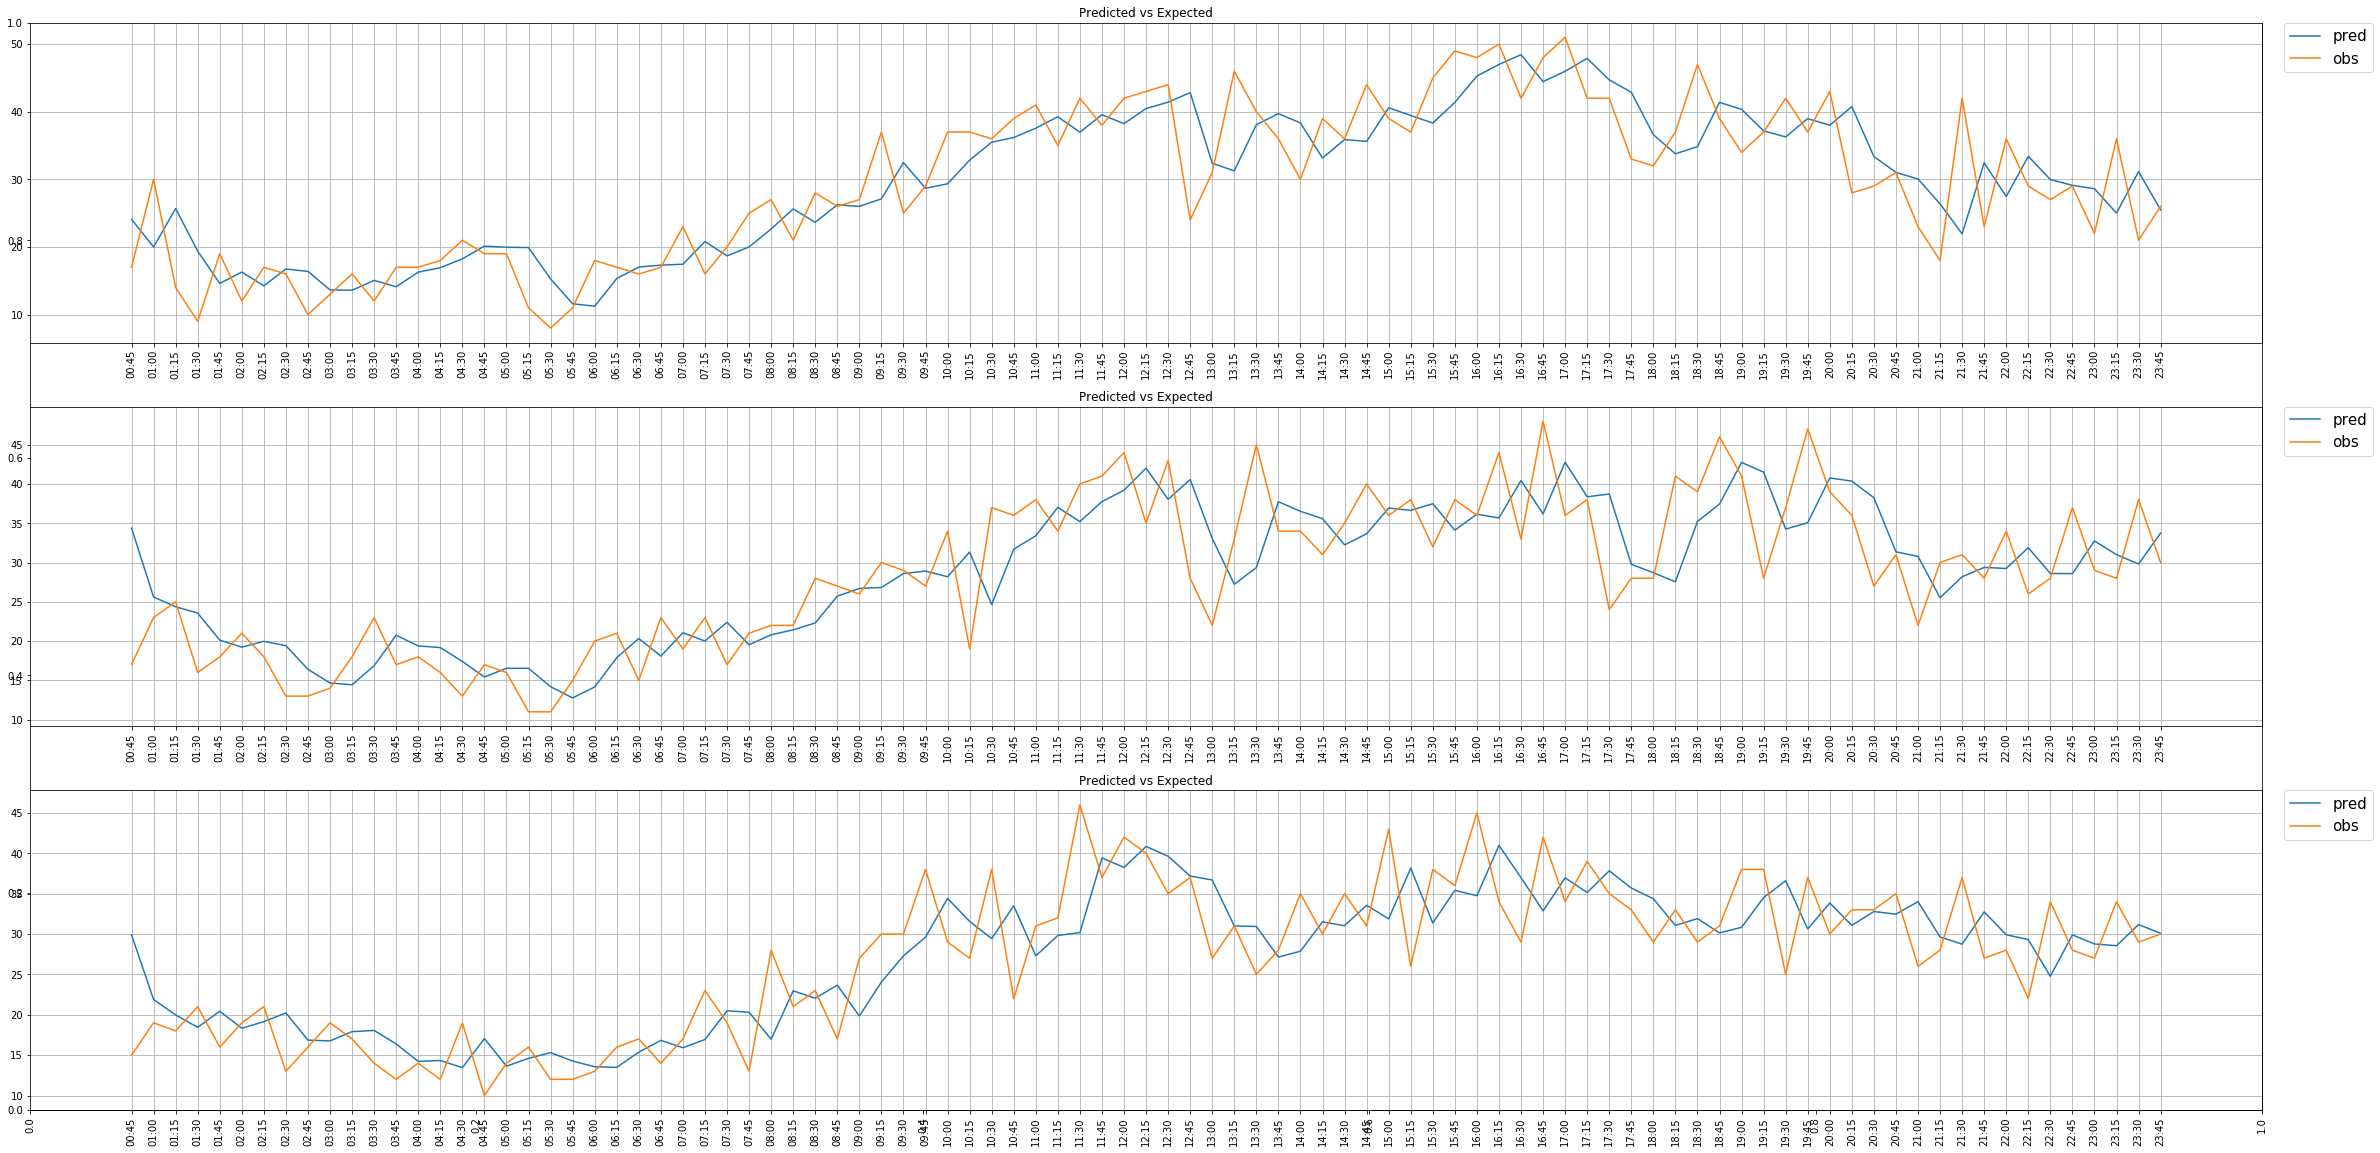

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
curr_dir = os.getcwd()


obs_df = pd.read_csv('3day_unsmoothed.csv')
obs = obs_df.values
obs = obs.astype('float32')

obsX, obsY = create_dataset(obs)
#print(obsX)
pred = model.predict(obsX)
#print(pred)
#print(obsY)

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 45), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]
print(len(pred[93:186]))
print(len(pred[186:279]))

#sys.exit()
#Esta feito para um gráfico ao longo de três dias 
def plot_results(dts, pred, obsY, plot_name):
    fig = plt.figure(1)
    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(dts,pred[0:93], label="pred")
    ax.plot(dts,obsY[0:93], label="obs")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax2 = fig.add_subplot(312)
    ax2.plot(dts, pred[93:186], label="pred")
    ax2.plot(dts,obsY[93:186], label="obs")
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax2.grid(True)
    ax2.set_title("Predicted vs Expected")
    ax2.tick_params(axis='x', rotation=90)

    ax3 = fig.add_subplot(313)
    ax3.plot(dts, pred[186:279], label="pred")
    ax3.plot(dts,obsY[186:279], label="obs")
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax3.grid(True)
    ax3.set_title("Predicted vs Expected")
    ax3.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig(curr_dir + "\\results_nn\\" +str(plot_name)+".png", dpi=100)
plot_results(dts, pred, obsY, "linear_reg")
#plot_changes(test, df_test)

In [40]:
#smoothing using z_score
#not great
from scipy import stats

import numpy as np

date = copy.deepcopy(train2.iloc[:,0])
values = copy.deepcopy(train2.iloc[:,1:])
cenas = values.values

z = np.abs(stats.zscore(values))
y = np.abs(stats.zscore(cenas))
threshold = 2
z_score = np.where(y > 3)
#print(cenas[1])
#print(cenas[1,-2])
#print(train2.columns[9])
#z_score doesnt really work very well
for i in z_score[0]:
    for j in z_score[1]:
        #dois casos especiais : 0h00 e 23h45
        if j == 0:
            #values.columns[j] == "0h00":
            #dostuff
            previous_t = cenas[i,-1]
            
            next_t = cenas[i,j+1]
            cenas[i,j] = (previous_t + next_t)/2
        if j == 95:
            #dostuff
            next_t = cenas[i,0]
            previous_t = cenas[i,j-1]
            cenas[i,j] = (previous_t + next_t)/2
        else:
            previous_t = cenas[i,j-1]
            next_t = cenas[i,j+1]
            cenas[i,j] = (previous_t + next_t)/2
            #values.loc[i,values.columns[j]] = (previous_t + next_t)/2


Text(0.5, 1.0, 'CEnAS')

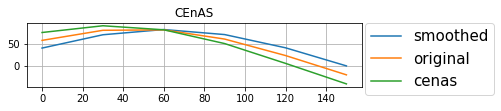

In [2]:
#print(dt2.head(10))
# split into train and test sets
#train_size = int(len(dt2) * 0.8)
#test_size = len(dt2) - train_size
#train, test = dt2[0:train_size,:], dt2[train_size:len(dt2),:]


#train2 = copy.deepcopy(train)
#for column in dt2:
#    if column == "Data":
#        continue
#    else:
#        mean = dt2[column].mean()
#        stdev = dt2[column].std()
#        dt2.loc[dt2[column] > (mean + 2*stdev), column] = mean
        
    
#train_size = int(len(dataset) * 0.8)
#test_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# split into train and test sets

#print(layer2.get_weights())